## Libs.

In [ ]:
!pip install pysurvival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 46.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp38-cp38-linux_x86_64.whl size=5572881 sha256=871afc1afaeb223c0c0bc34b61aae3840b743e97934f1bbc292cbc4e498cd39f
  Stored in directory: /root/.cache/pip/wheels/7d/91/3f/2f7fbe287fc5aad2034935fe8e6c8bb3c56bf28c207fe9d700
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12081 sha256=0417deab693ce0bbd3c9cb093abaa5dbbc1c1877353231a90bbea725497fe470
  Stored in directory: /root/.cache/pip/wheels/2c/67/ed/d84123843c937d7e7f5ba88a270d11036473144143355e2747
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=5e54cd011bf7056e68d9be74fcdc5c2bbf6ea24e77423e17716fb61ab77f0e94
  

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from lightgbm import LGBMRegressor
import dateutil.relativedelta as relativedelta
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

pd.set_option('display.max_columns', None)

## Data Prep

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/arghanath007/Atliq-Mart-FMCG-Supply-Chain-Dashboard/master/Resources%20and%20information%20Given/fact_order_lines.csv")
data['actual_delivery_date'] = pd.to_datetime(data['actual_delivery_date'])

data = data[["actual_delivery_date","customer_id","product_id","order_qty"]]
data["order_qty"] = data.groupby(["customer_id","product_id"]).transform(lambda x: ((x - x.mean()*1.15).clip(0)).round())

data.head()

<ipython-input-3-234a998aad8b>:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  data["order_qty"] = data.groupby(["customer_id","product_id"]).transform(lambda x: ((x - x.mean()*1.15).clip(0)).round())


actual_delivery_date  customer_id  product_id  order_qty
0           2022-03-04       789203    25891601        0.0
1           2022-03-02       789320    25891203        0.0
2           2022-03-03       789320    25891203        0.0
3           2022-03-04       789220    25891203        0.0
4           2022-03-03       789703    25891203        0.0

In [ ]:
# frame the data
data = data.set_index("actual_delivery_date")
data = data.groupby(["customer_id","product_id"])["order_qty"].resample("D").sum().reset_index()

In [ ]:
# check tha last date of sales on sku level
data.groupby(["customer_id","product_id"]).actual_delivery_date.max()

customer_id  product_id
789101       25891101     2022-08-28
             25891102     2022-09-01
             25891103     2022-08-30
             25891201     2022-08-31
             25891202     2022-09-01
                             ...    
789903       25891502     2022-08-31
             25891503     2022-09-02
             25891601     2022-08-31
             25891602     2022-08-29
             25891603     2022-08-31
Name: actual_delivery_date, Length: 630, dtype: datetime64[ns]

In [ ]:
# padding the date range with zero values
data = data.set_index('actual_delivery_date')\
.groupby(["customer_id","product_id"])["order_qty"]\
.apply(lambda df: df.reindex(pd.date_range(start = df.index.min(), # starts from first sale of customer X product
                                           end = data.actual_delivery_date.max(), # ends at last sale of data
                                           freq = 'D')
                             )
         ).fillna(0).reset_index()

data.columns = ["customer_id","product_id","date","order_qty"]
data.head(3)

customer_id  product_id       date  order_qty
0       789101    25891101 2022-03-02       12.0
1       789101    25891101 2022-03-03        0.0
2       789101    25891101 2022-03-04        0.0

In [ ]:
# control the results
data.groupby(["customer_id","product_id"]).date.max()

customer_id  product_id
789101       25891101     2022-09-03
             25891102     2022-09-03
             25891103     2022-09-03
             25891201     2022-09-03
             25891202     2022-09-03
                             ...    
789903       25891502     2022-09-03
             25891503     2022-09-03
             25891601     2022-09-03
             25891602     2022-09-03
             25891603     2022-09-03
Name: date, Length: 630, dtype: datetime64[ns]

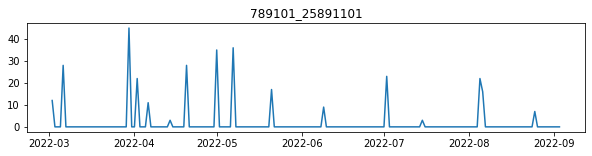

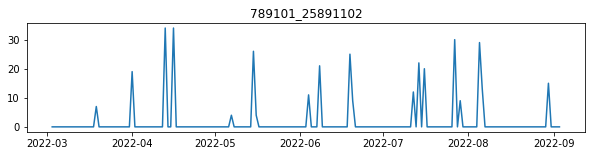

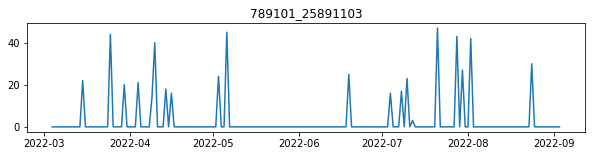

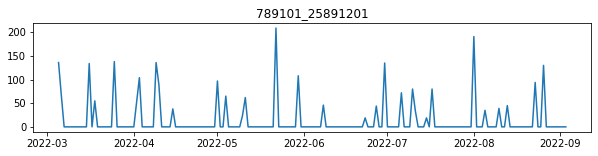

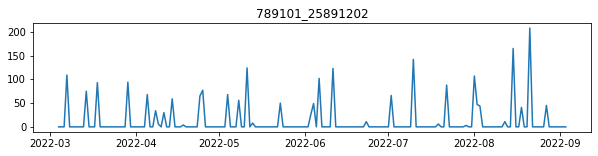

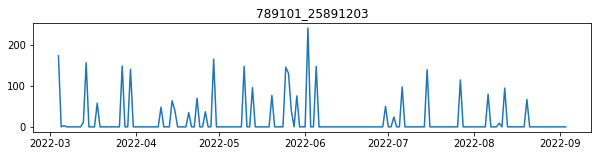

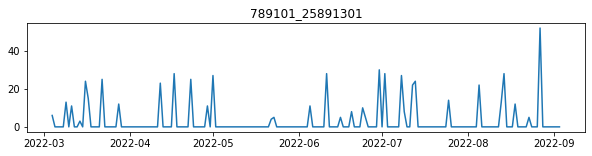

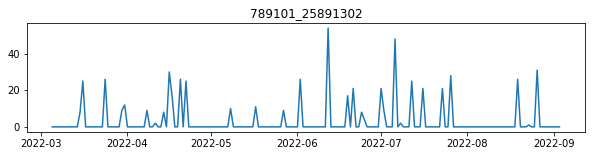

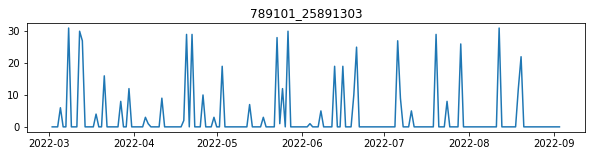

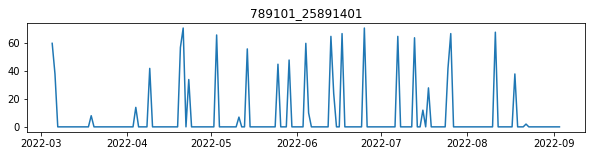

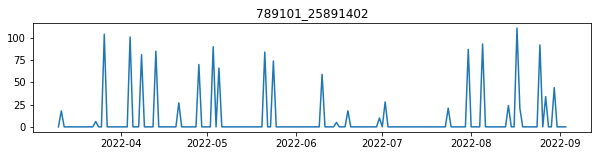

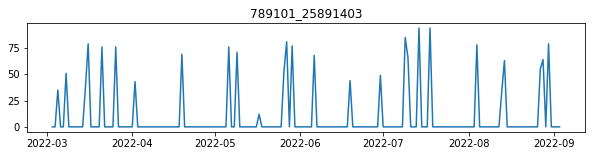

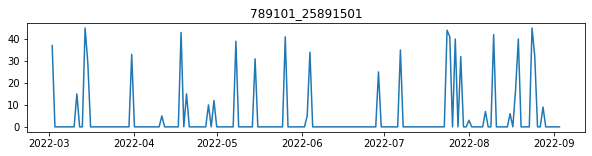

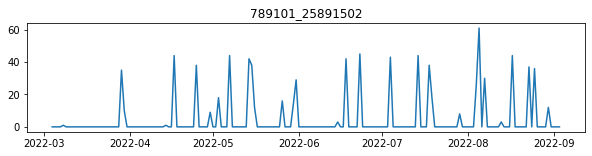

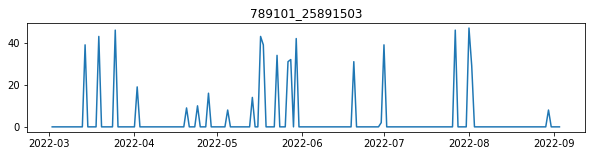

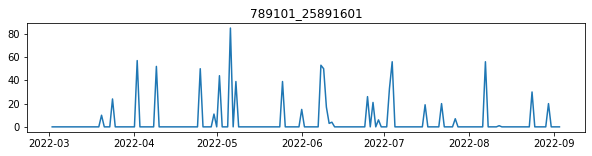

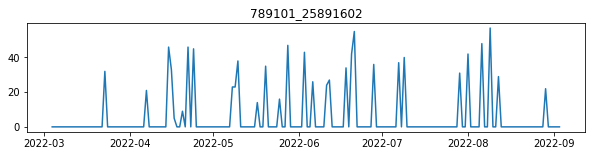

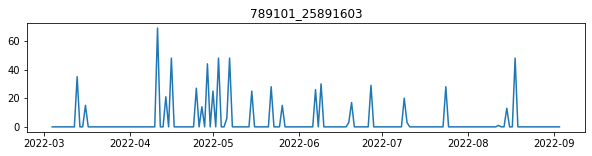

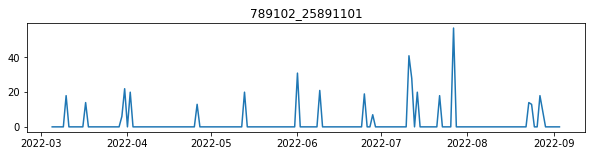

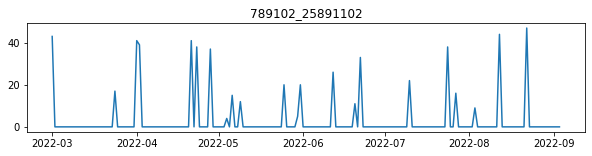

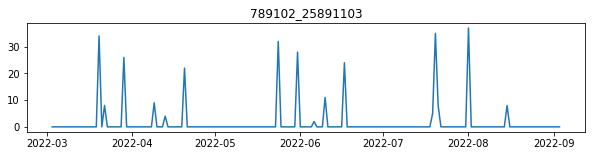

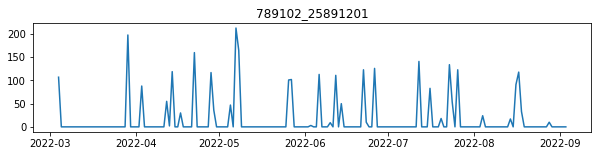

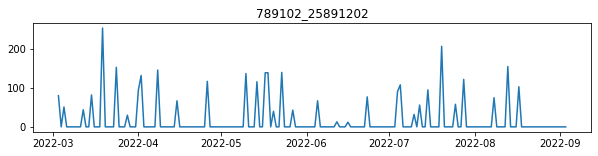

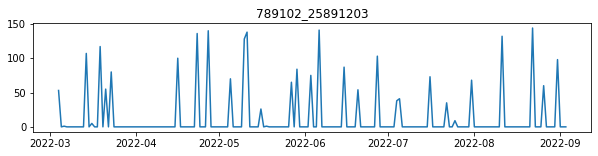

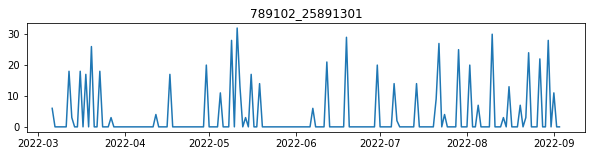

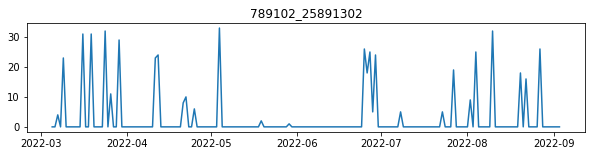

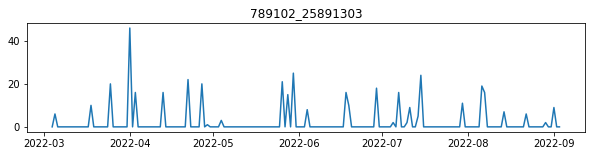

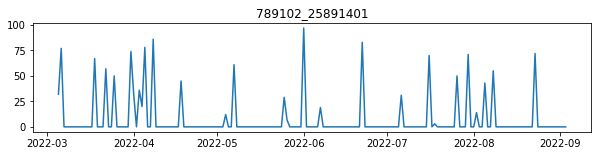

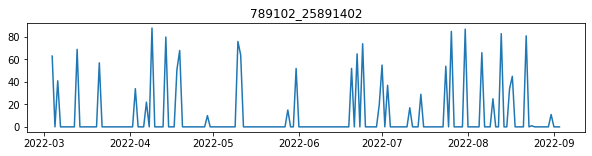

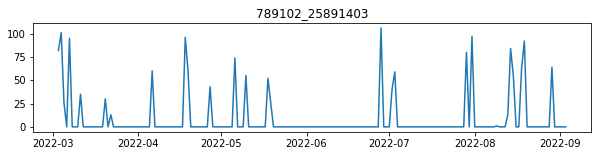

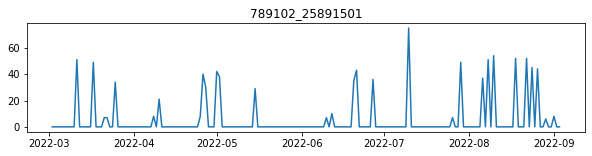

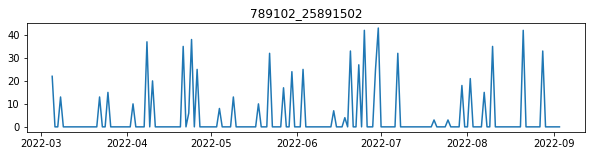

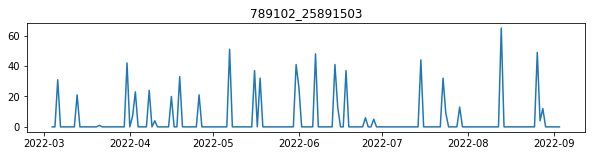

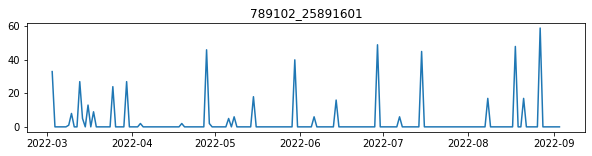

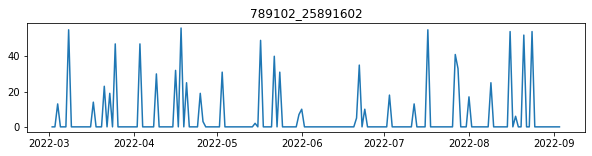

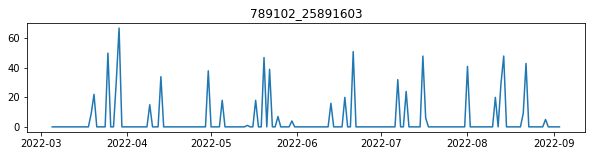

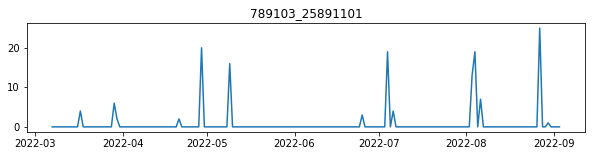

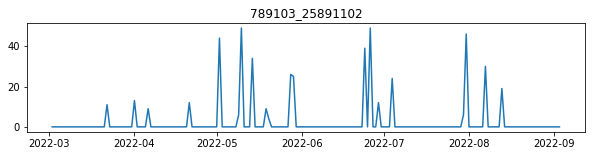

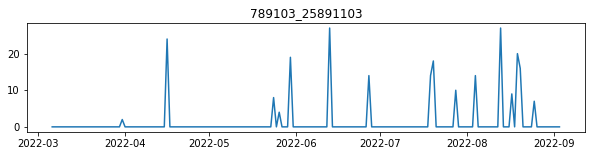

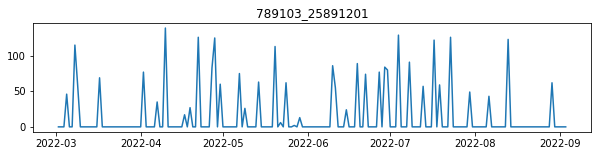

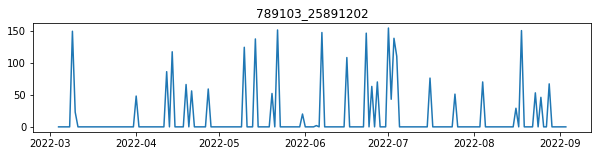

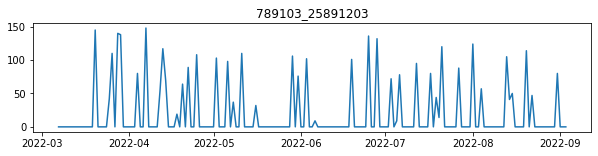

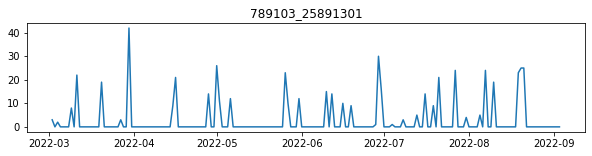

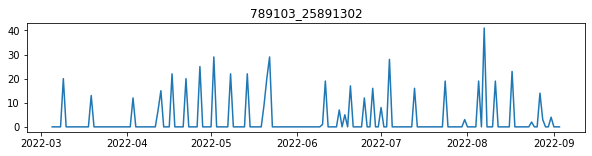

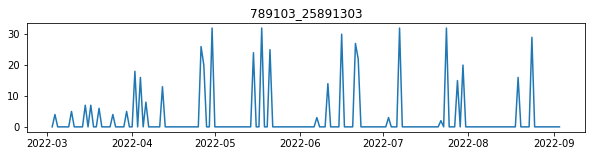

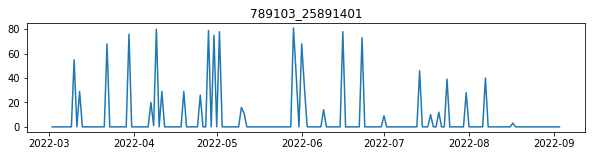

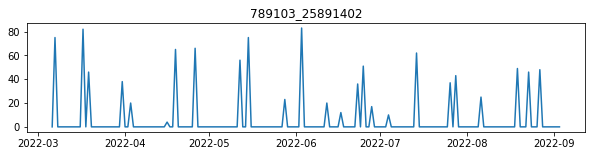

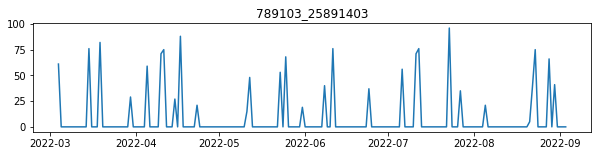

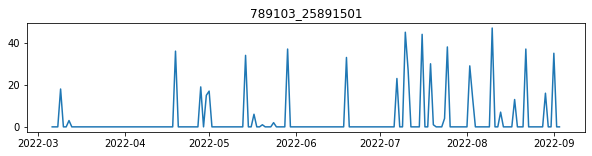

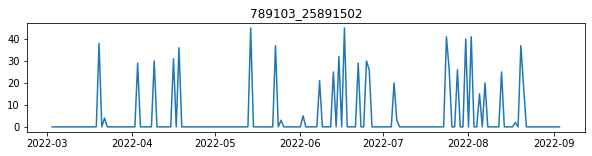

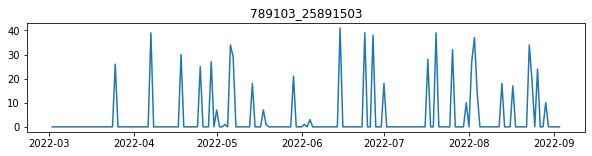

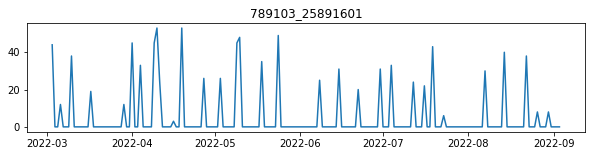

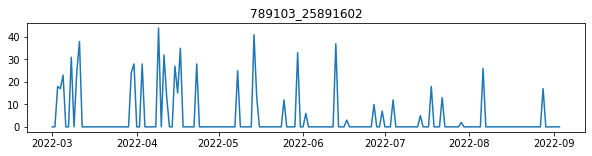

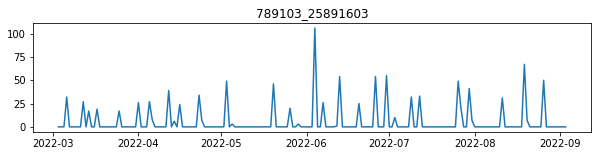

In [ ]:
# plot the sales
for c in data.customer_id.unique()[:3]:
  for p in data[data.customer_id == c].product_id.unique():

    ser = data[(data.customer_id == c)&(data.product_id == p)]
    title = str(c) + "_" + str(p)

    plt.figure(figsize=(10, 2))
    plt.plot(ser.date,ser.order_qty)
    plt.title(title)
    plt.show()


In [ ]:
data.describe()

customer_id    product_id      order_qty
count  115751.000000  1.157510e+05  115751.000000
mean   789427.856684  2.589135e+07       6.086384
std       223.578826  1.707963e+02      19.995606
min    789101.000000  2.589110e+07       0.000000
25%    789220.000000  2.589120e+07       0.000000
50%    789420.000000  2.589130e+07       0.000000
75%    789603.000000  2.589150e+07       0.000000
max    789903.000000  2.589160e+07     310.000000

## Demand Forecast

In [ ]:
from prophet import Prophet

In [ ]:
# add two higher granularity level for prediction
data["product_grp"] = data.product_id.apply(lambda x: int(str(x)[:6]))
data["customer_grp"] = data.customer_id.apply(lambda x: int(str(x)[:4]))

data = data[["customer_id","customer_grp","product_id","product_grp","date","order_qty"]]
data.head(3)

customer_id  customer_grp  product_id  product_grp       date  order_qty
0       789101          7891    25891101       258911 2022-03-02       12.0
1       789101          7891    25891101       258911 2022-03-03        0.0
2       789101          7891    25891101       258911 2022-03-04        0.0

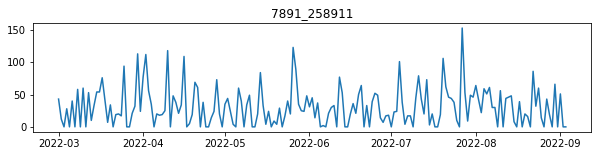

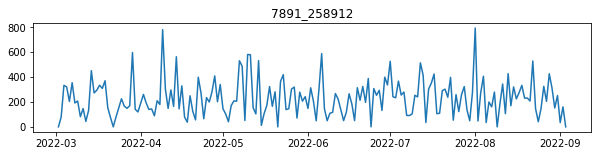

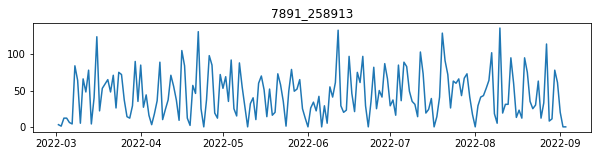

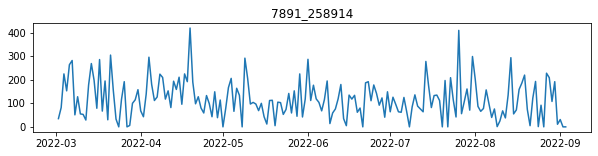

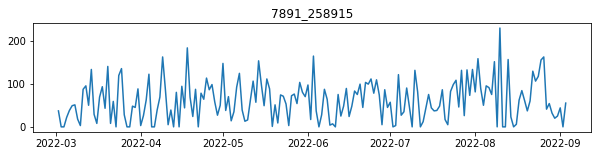

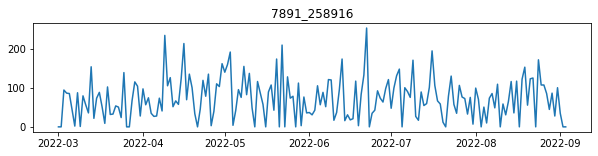

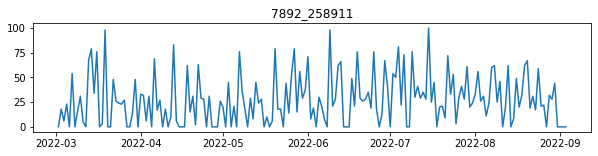

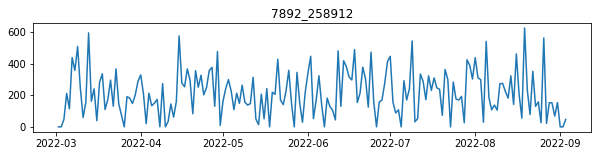

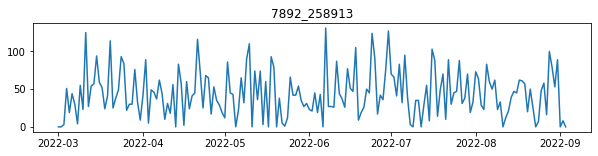

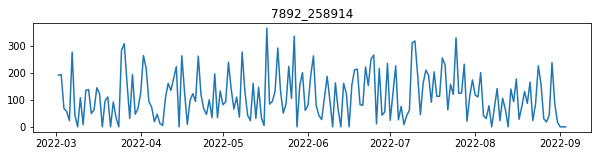

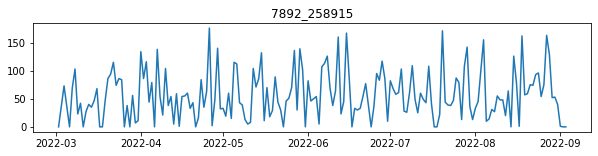

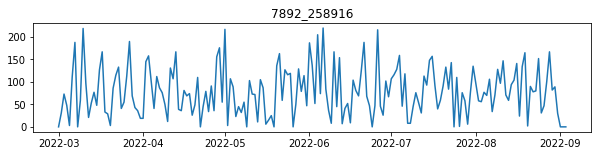

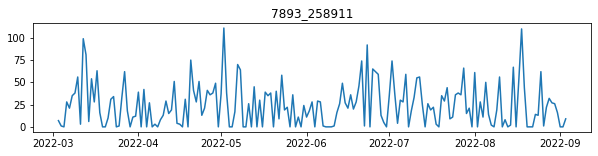

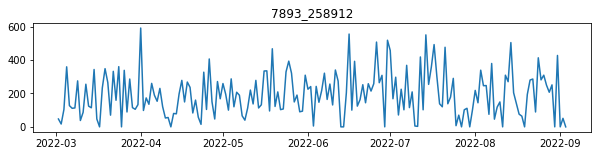

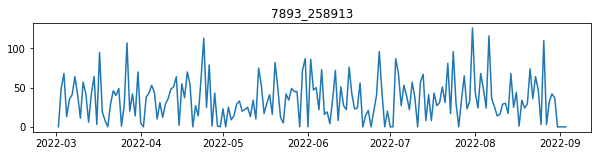

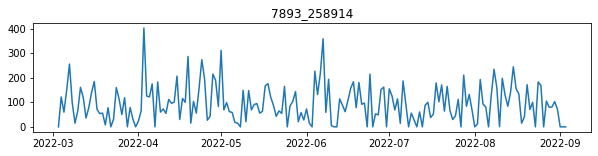

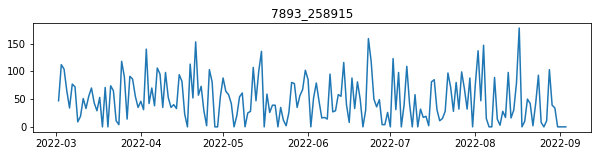

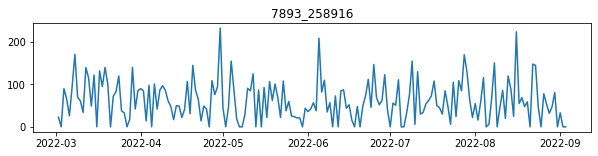

In [ ]:
# plot the sales
for c in data.customer_grp.unique()[:3]:
  for p in data[data.customer_grp == c].product_grp.unique():

    ser = data[(data.customer_grp == c)&(data.product_grp == p)].groupby("date")["order_qty"].sum().reset_index()
    title = str(c) + "_" + str(p)

    plt.figure(figsize=(10, 2))
    plt.plot(ser.date,ser.order_qty)
    plt.title(title)
    plt.show()


In [ ]:
#args.
granularity_level = ["customer_grp","product_grp"]
date_col = 'date'
target_col = 'order_qty'


# define prediction freq & level
df = data.copy()
df = df.set_index(date_col)
df = df.groupby(granularity_level)[target_col].resample("W").sum().reset_index()

df.head()

customer_grp  product_grp       date  order_qty
0          7891       258911 2022-03-06      123.0
1          7891       258911 2022-03-13      181.0
2          7891       258911 2022-03-20      299.0
3          7891       258911 2022-03-27      150.0
4          7891       258911 2022-04-03      435.0

In [ ]:
# args.
shifts = range(6,-3,-1)
values_col = 'order_qty'
granularity_level = ['customer_grp','product_grp']
date_col = 'date'


# order values
df = df.sort_values(granularity_level + [date_col], ascending=True).reset_index(drop=True)

# create input & targets
for shift in shifts:
  if shift > 0:
    df[f'{values_col}_shifted_{shift}'] = df.groupby(granularity_level)[values_col].shift(shift).diff()
  else:
    df[f'{values_col}_in_{-shift}_periods'] = df.groupby(granularity_level)[values_col].shift(shift)

# drop zero line
drop = [c for c in df.columns if 'in_0_period' in c] + [values_col]
df = df.drop(columns=drop)

# set date as index (timeseries_train_test_split requires date as index)
df = df.set_index('date')
df.head(3)

customer_grp  product_grp  order_qty_shifted_6  \
date                                                         
2022-03-06          7891       258911                  NaN   
2022-03-13          7891       258911                  NaN   
2022-03-20          7891       258911                  NaN   

            order_qty_shifted_5  order_qty_shifted_4  order_qty_shifted_3  \
date                                                                        
2022-03-06                  NaN                  NaN                  NaN   
2022-03-13                  NaN                  NaN                  NaN   
2022-03-20                  NaN                  NaN                  NaN   

            order_qty_shifted_2  order_qty_shifted_1  order_qty_in_1_periods  \
date                                                                           
2022-03-06                  NaN                  NaN                   181.0   
2022-03-13                  NaN                  NaN                   299.0   
2022-03-20                  NaN                 58.0                   150.0   

            order_qty_in_2_periods  
date                                
2022-03-06                   299.0  
2022-03-13                   150.0  
2022-03-20                   435.0

In [ ]:
# time series predictor
def ts_predictor(y_train, y_test):

    # rename columns
    name_dict = {"date": "ds"}
    name_dict.update({c:"y" for c in df.columns for i in range(1,10) if f"in_{i}_period" in c})

    ts_trn = y_train.reset_index()
    ts_trn = ts_trn.rename(columns = name_dict)
    ts_tst = y_test.reset_index()
    ts_tst = ts_tst.rename(columns = name_dict)

    # build the model
    ts_model = Prophet(uncertainty_samples=False,
                       daily_seasonality=False,
                       weekly_seasonality=False,
                       yearly_seasonality=False,
                       ).add_seasonality(
                         name="weekly",
                         period=7,
                         fourier_order=5
                       ).add_seasonality(
                         name="monthly",
                         period=30.5,
                         fourier_order=5
                       ).add_seasonality(
                         name="yearly",
                         period=365.25,
                         fourier_order=5
                       )
    # fit & predict
    ts_model.fit(ts_trn)
    p_tr = ts_model.predict(ts_trn)[["ds","yhat"]]
    p_tst = ts_model.predict(ts_tst)[["ds","yhat"]]
        
    return p_tst["yhat"].values

In [ ]:
def timeseries_train_test_split(x, y, threshold:str, last_n_to_train=20, last_n_to_test=1):
    
    n = last_n_to_train + last_n_to_test

    x_test = x[x.index.get_level_values(0) <= threshold].tail(n)
    y_test = y[y.index.get_level_values(0) <= threshold].tail(n)
    
    x_train, x_test = x_test.head(last_n_to_train), x_test.tail(last_n_to_test)
    y_train, y_test = y_test.head(last_n_to_train), y_test.tail(last_n_to_test)
    
    return x_train, x_test, y_train, y_test

INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdonyafa1/5l677oep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdonyafa1/_9_z9btk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44299', 'data', 'file=/tmp/tmpdonyafa1/5l677oep.json', 'init=/tmp/tmpdonyafa1/_9_z9btk.json', 'output', 'file=/tmp/tmpdonyafa1/prophet_modela02rt41p/prophet_model-20230217111540.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:15:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:15:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdonyafa1/w0f9i6ur.json
DEBUG:cmdstanpy:input tempfil

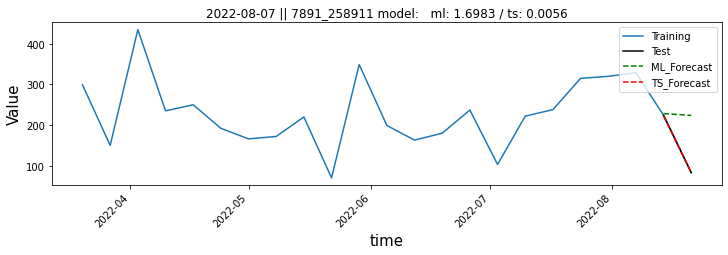

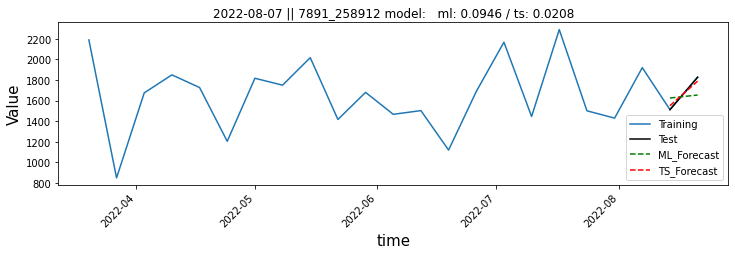

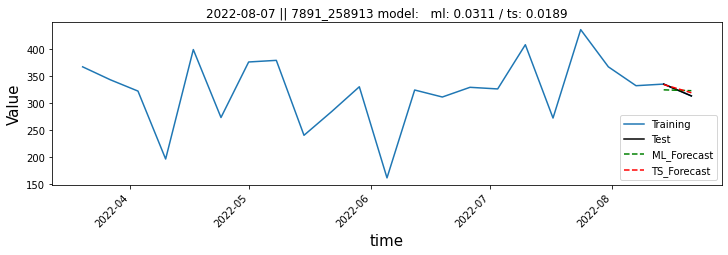

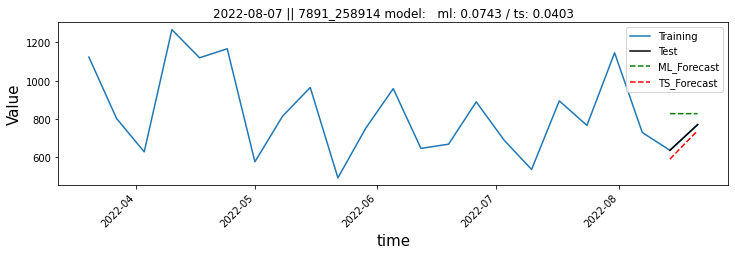

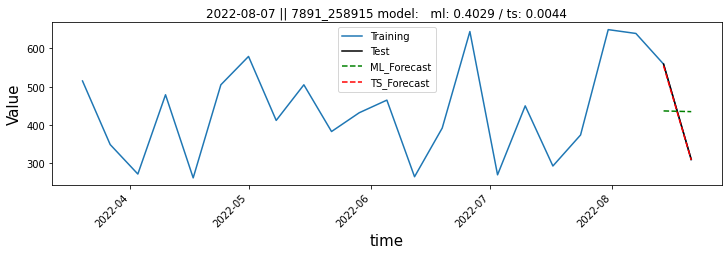

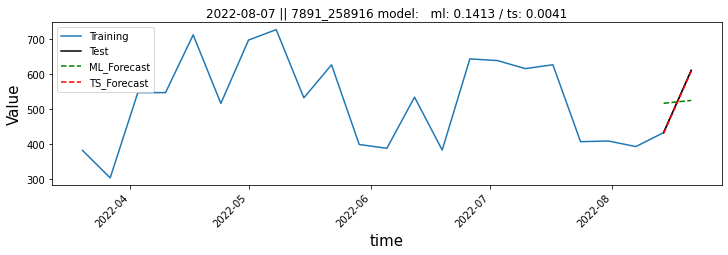

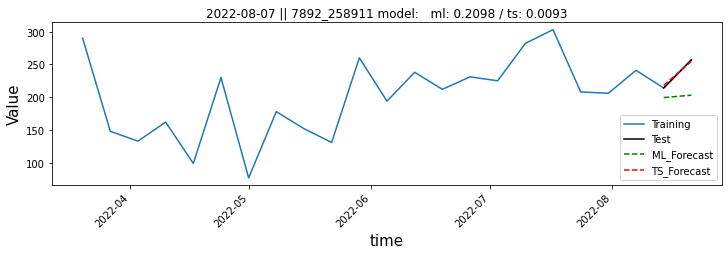

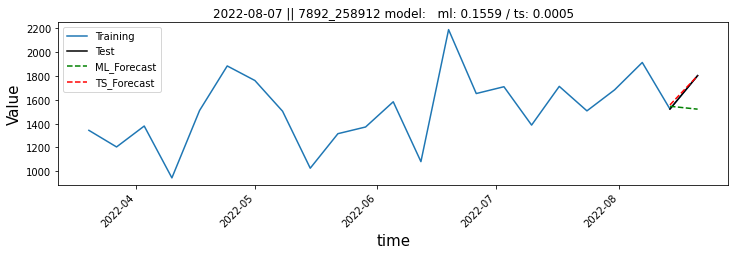

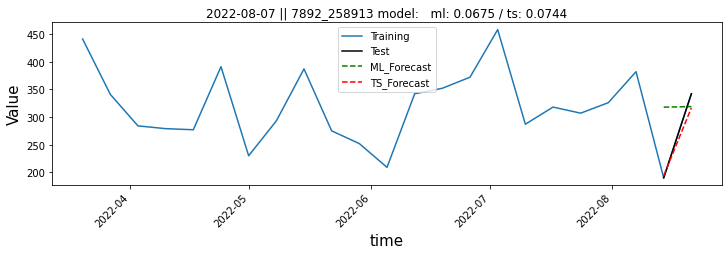

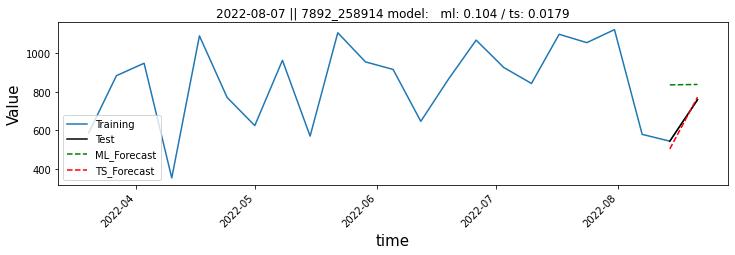

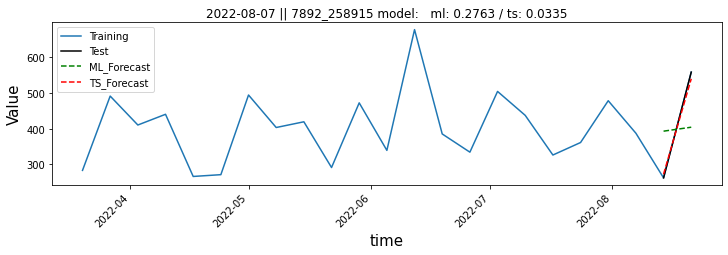

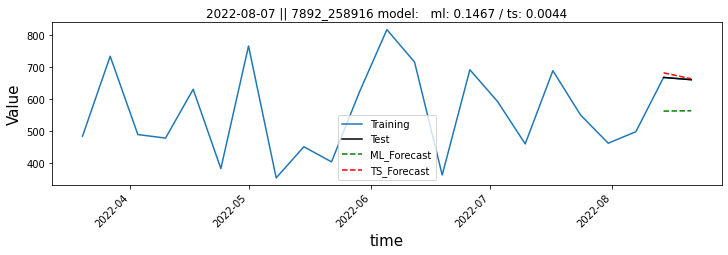

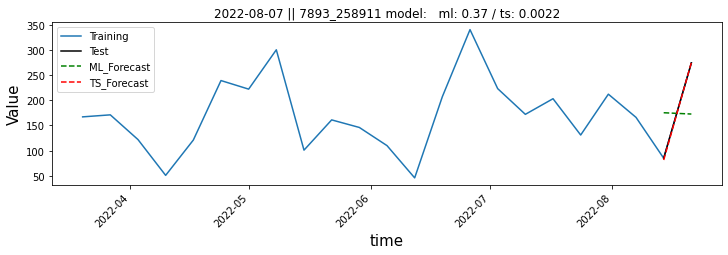

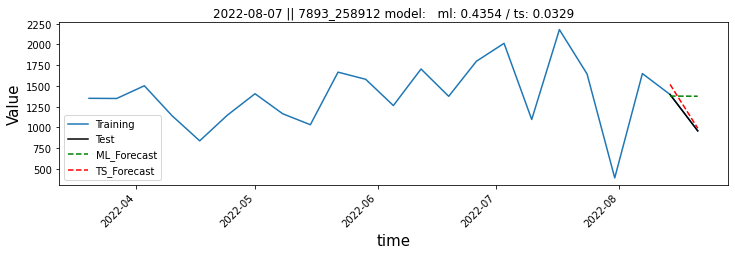

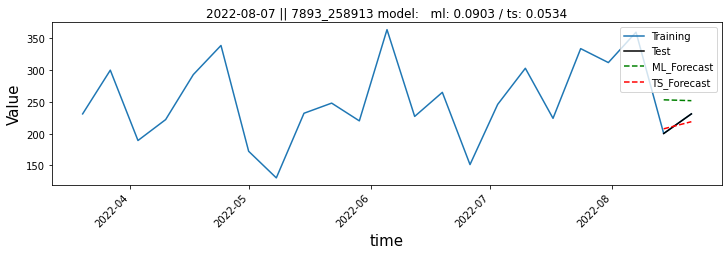

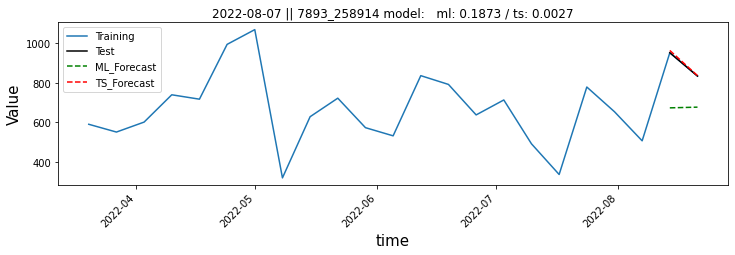

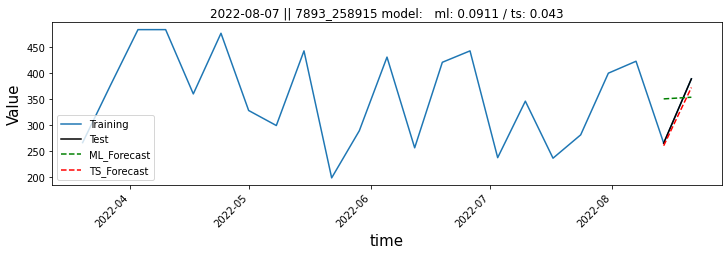

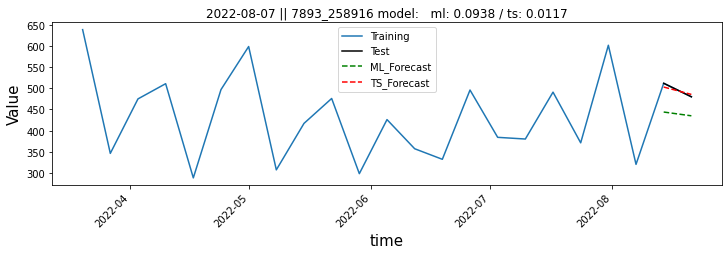

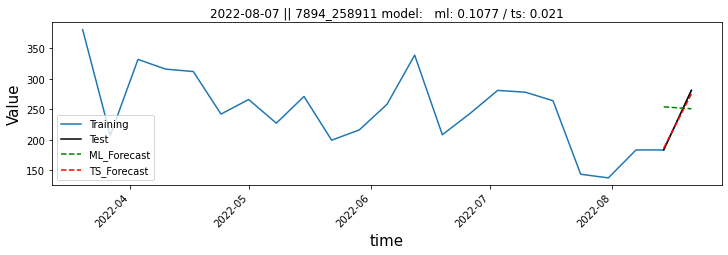

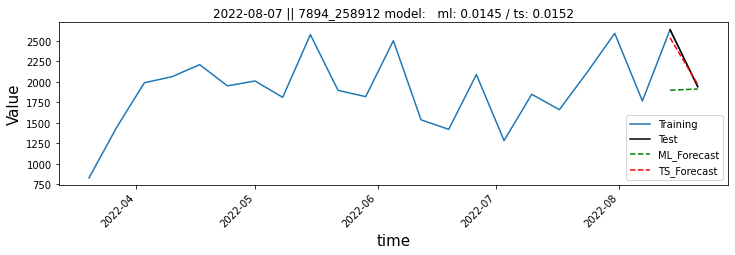

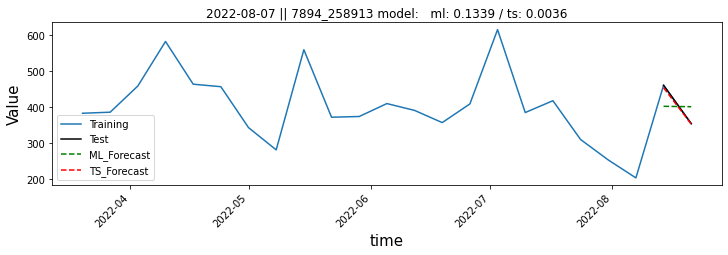

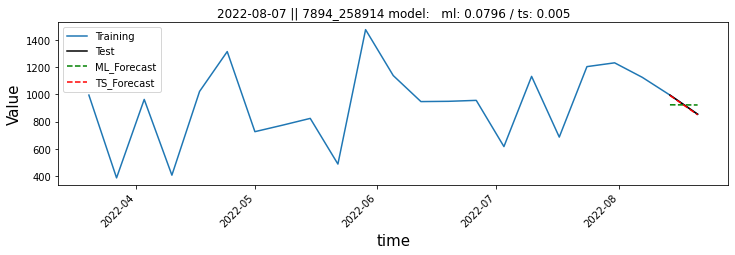

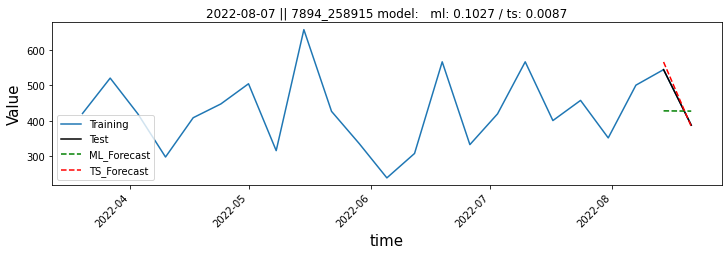

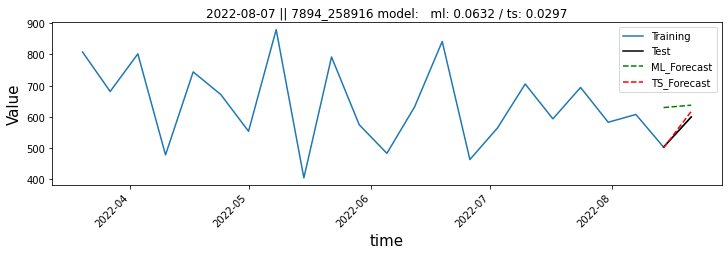

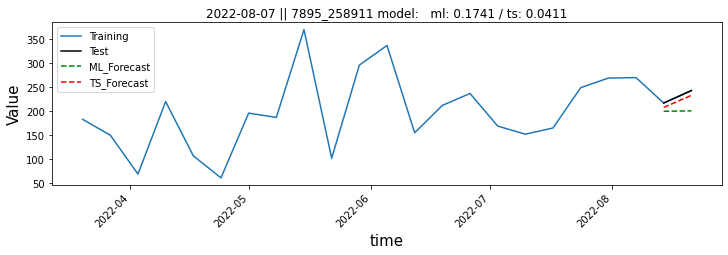

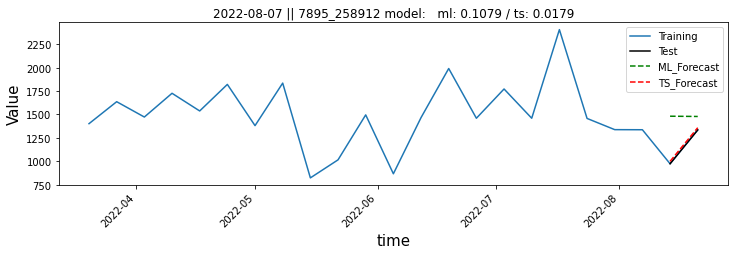

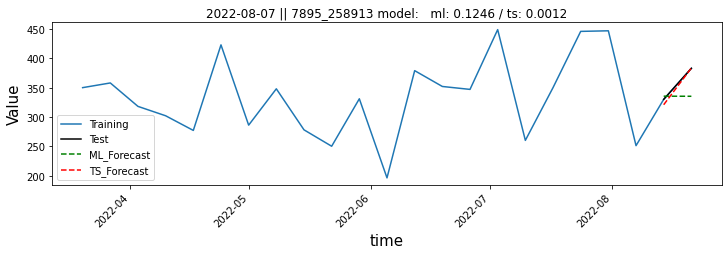

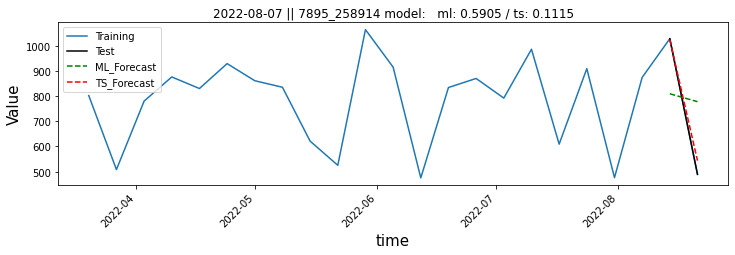

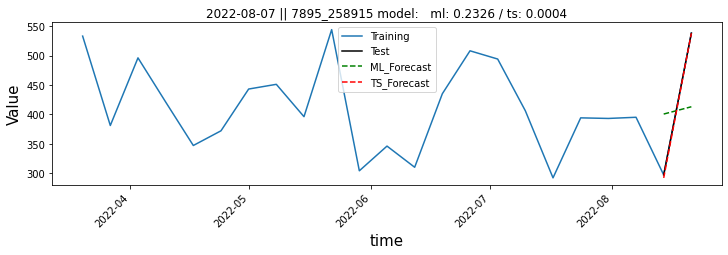

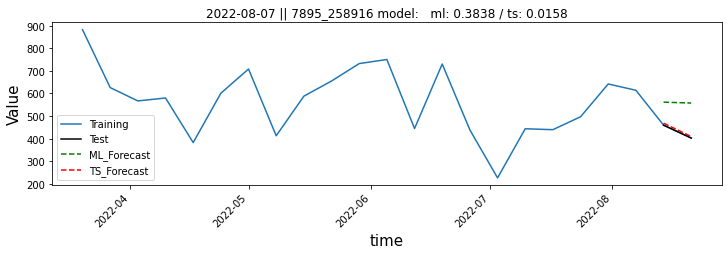

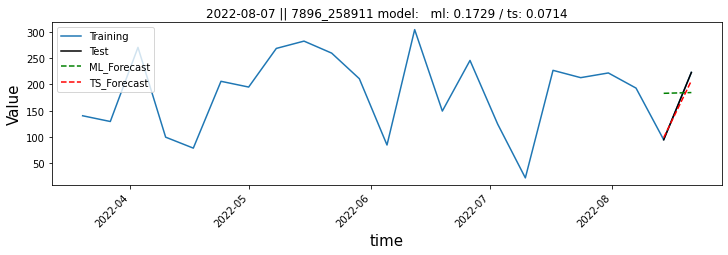

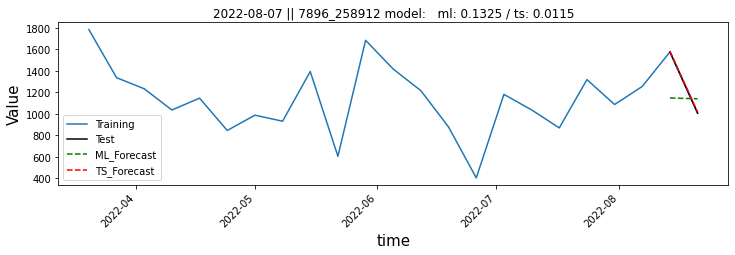

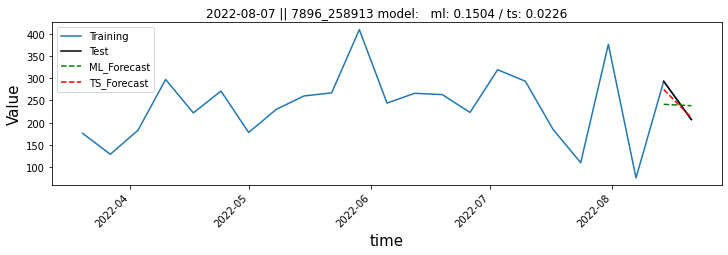

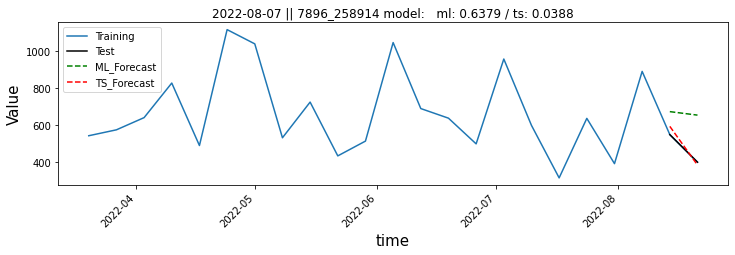

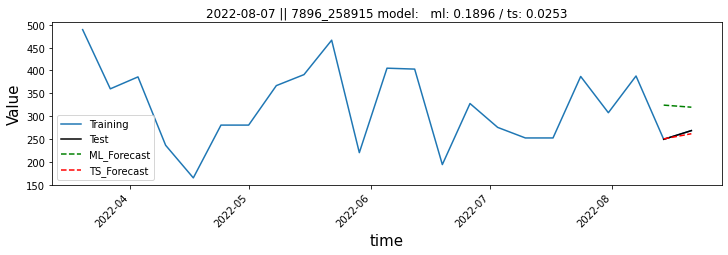

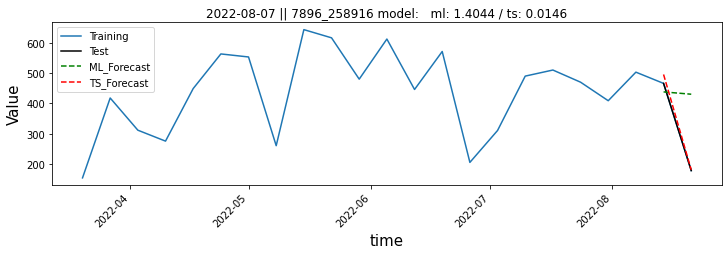

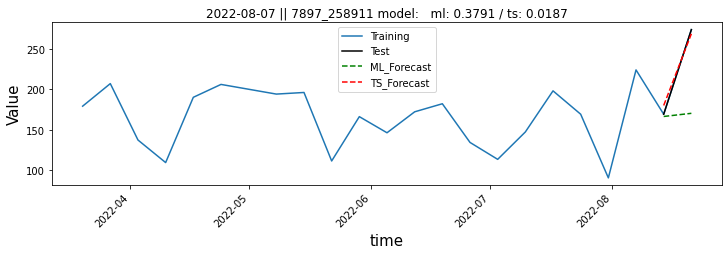

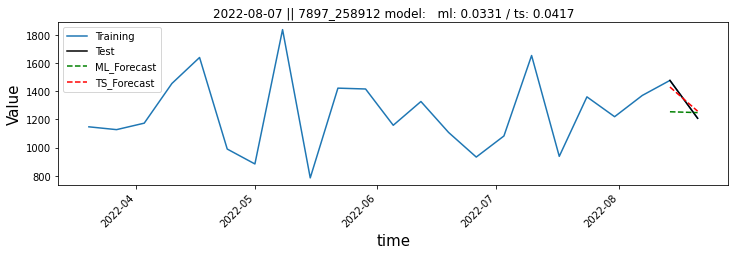

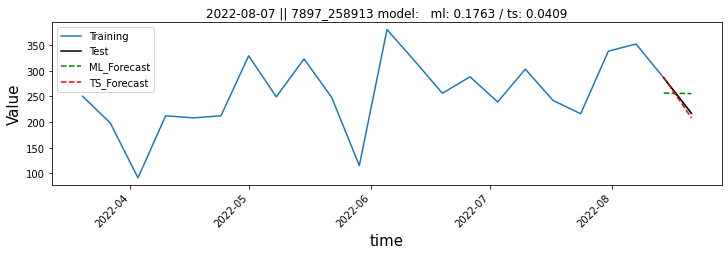

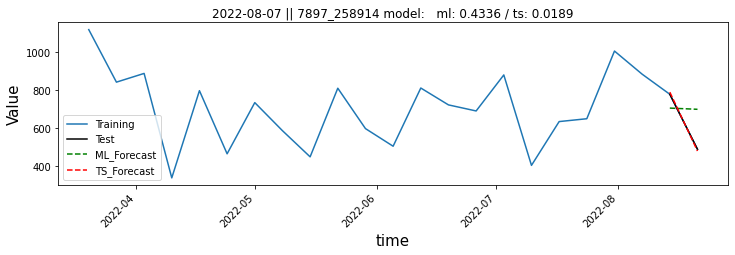

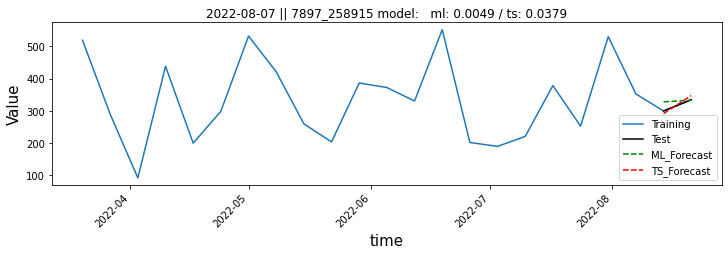

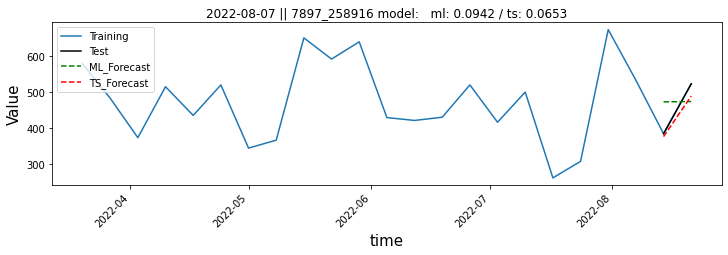

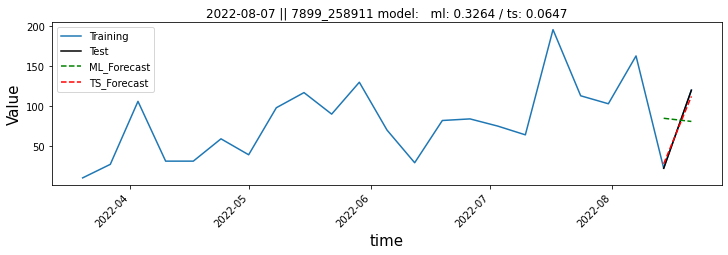

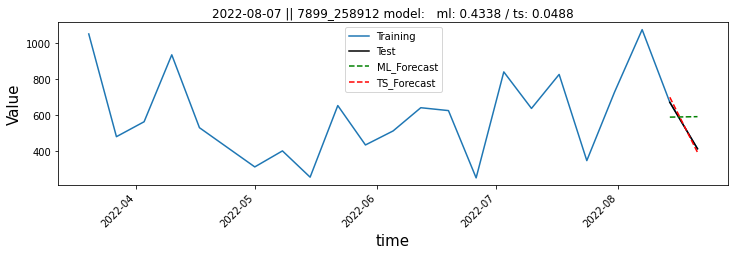

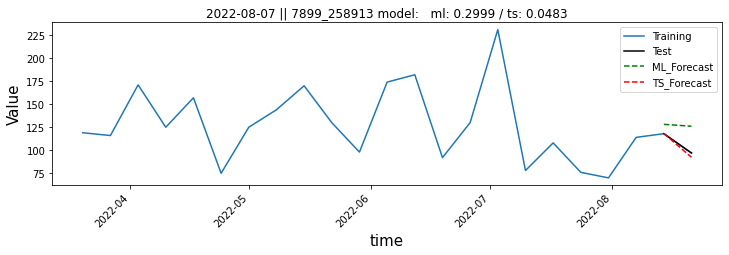

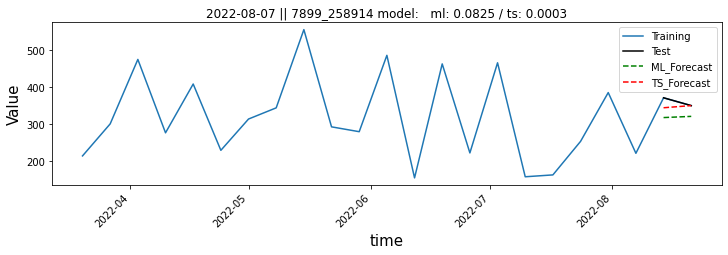

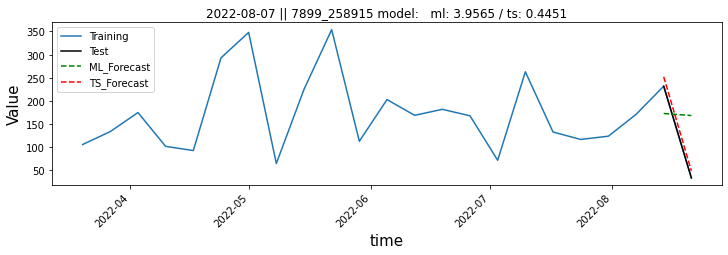

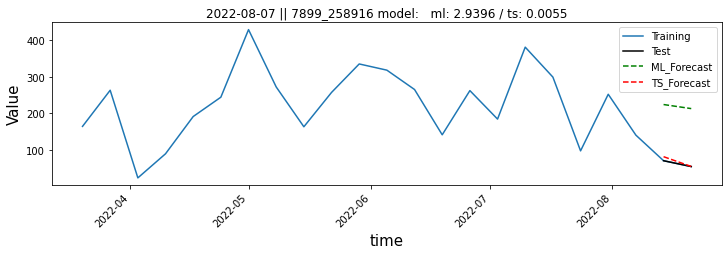

In [ ]:
## PREDICTION FOR SINGLE EXAMPLE
n_train = 60   # trainin size
n_test = 1   # test size
effective_list = [c for c in data.columns if 'order_qty_shifted' in c] # list of inputs

freq = 'Day' # data frequence
first_run = '2022-08-07'
last_run = '2022-08-07'



# define model
model = LGBMRegressor(n_estimators = 100,
                      learning_rate = 0.1,
                      num_leaves = 16,
                      max_depth = 32,
                      reg_alpha = 5,
                      seed=52)

# define target values
targets = [t for t in df.columns if 'order_qty_in' in t]

# loop for different run_date
predictions = pd.DataFrame()
for d in pd.date_range(start=first_run, end=last_run, freq=freq[0]):
    for customer in df.customer_grp.unique():
        for product in df[(df.customer_grp == customer)].product_grp.unique():
            for t in targets:
        
                # Select inputs & outputs
                x = df[(df.customer_grp == customer)&
                          (df.product_grp == product)].drop(columns = targets)
                y = df[(df.customer_grp == customer)&
                          (df.product_grp == product)][[t]]

                # Manuel feature selection
                if effective_list:
                    x = x[effective_list]

                # Split train&test
                x_train, x_test, y_train, y_test = timeseries_train_test_split(x, y, threshold = d, 
                                                                               last_n_to_train = n_train,
                                                                               last_n_to_test = n_test)               

                # train the model & make the predictions
                model.fit(x_train, y_train)
                p = model.predict(x_test)

                p_ts = ts_predictor(y_train, y_test)

                # calculate run_date
                if n_test == 1:
                    rundate = d
                else:
                    if freq == 'Day':
                        rundate = d - relativedelta.relativedelta(days = n_test - 1)
                    elif freq == 'Week':
                        rundate = d - relativedelta.relativedelta(weeks = n_test - 1)
                    elif freq == 'Month':
                        rundate = d - relativedelta.relativedelta(months = n_test - 1)

                # Write the results in dict.
                pred = y_test.reset_index()
                pred = pred.rename(columns={'order_qty_in_1_periods':'order_qty',
                                            'order_qty_in_2_periods':'order_qty'})
                pred['date'] = pred["date"][0] + relativedelta.relativedelta(weeks = int(t.split('_')[3]))
                pred['prediction'] = p
                pred['prediction_ts'] = p_ts
                pred['run_date'] = rundate
                pred['customer_grp'] = customer
                pred['product_grp'] = product
                predictions = pd.concat([predictions,pred]).fillna(0)
            
            
            # calculate the mape
            mape = mean_absolute_percentage_error(pred[pred.run_date == d]["order_qty"],
                                                  pred[pred.run_date == d]["prediction"]
                                             ).round(4)

            mape_ts = mean_absolute_percentage_error(pred[pred.run_date == d]["order_qty"],
                                                  pred[pred.run_date == d]["prediction_ts"]
                                             ).round(4)

            # Plot of All-Series + Pred.
            fig_pred = predictions[(predictions.run_date == d)&
                                   (predictions.customer_grp == customer)&
                                   (predictions.product_grp == product)]
            fig_trn = df[(df.customer_grp == customer)&
                         (df.product_grp == product)&
                         (df.index.get_level_values(0) <= d)][[t]].tail(n_train)\
                                    .rename(columns = {"order_qty_in_1_periods":"order_qty",
                                                       "order_qty_in_2_periods":"order_qty"})
            fig_trn.index = fig_trn.index.map(lambda x: x + relativedelta.relativedelta(weeks = int(t.split('_')[3])))

            fig, ax = plt.subplots(1, figsize=(12, 3))
            ax.plot(fig_trn.index, fig_trn, label= 'Training')
            ax.plot(fig_pred.date, 
                    fig_pred.order_qty, 
                    label= 'Test', color='black')
            ax.plot(fig_pred.date, 
                    fig_pred.prediction, 
                    label= 'ML_Forecast', color='green', linestyle='dashed')
            ax.plot(fig_pred.date, 
                    fig_pred.prediction_ts, 
                    label= 'TS_Forecast', color='red', linestyle='dashed')

            msg = str(d.date()) +' || '+ str(customer) + "_" + str(product) +' model:   ' + 'ml: ' + str(mape) + " / " + 'ts: ' + str(mape_ts)
            _ = ax.set_title(msg)
            ax.set_ylabel("Value", fontsize = 15)
            ax.set_xlabel("time", fontsize = 15)
            plt.xticks(rotation=45, ha='right')
            ax.legend();
        

In [ ]:
predictions.head()

date  order_qty   prediction  prediction_ts   run_date  customer_grp  \
0 2022-08-14      224.0   228.217391     222.436459 2022-08-07          7891   
0 2022-08-21       83.0   223.956522      82.531460 2022-08-07          7891   
0 2022-08-14     1511.0  1624.260870    1549.357790 2022-08-07          7891   
0 2022-08-21     1826.0  1653.217391    1788.011064 2022-08-07          7891   
0 2022-08-14      335.0   324.304348     334.117430 2022-08-07          7891   

   product_grp  
0       258911  
0       258911  
0       258912  
0       258912  
0       258913

In [ ]:
# pick prediction
ml_mape = np.mean(abs(predictions.order_qty - predictions.prediction)).round(4)
ts_mape = np.mean(abs(predictions.order_qty - predictions.prediction_ts)).round(4)
print("ml: ", ml_mape)
print("ts: ", ts_mape)
print("----------------")
if ml_mape <= ts_mape:
  predictions = predictions.drop(columns=["prediction_ts"])
  print("ml_pred is selected")
  
elif ts_mape < ml_mape:
  predictions = predictions\
                  .drop(columns=["prediction"])\
                  .rename(columns={"prediction_ts":"prediction"})
  print("ts_pred is selected")

predictions.head()

ml:  109.2962
ts:  14.9572
----------------
ts_pred is selected


date  order_qty   prediction   run_date  customer_grp  product_grp
0 2022-08-14      224.0   222.436459 2022-08-07          7891       258911
0 2022-08-21       83.0    82.531460 2022-08-07          7891       258911
0 2022-08-14     1511.0  1549.357790 2022-08-07          7891       258912
0 2022-08-21     1826.0  1788.011064 2022-08-07          7891       258912
0 2022-08-14      335.0   334.117430 2022-08-07          7891       258913

## Survival Prep

In [ ]:
from pysurvival.models.multi_task import NeuralMultiTaskModel, LinearMultiTaskModel
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel, ConditionalSurvivalForestModel, RandomSurvivalForestModel
from pysurvival.utils.display import compare_to_actual

In [ ]:
from datetime import timedelta


def date_finder(x,
                freq: str,
                start=False):
    x =  pd.to_datetime(x)
    if freq == "W":
        start_date = x - timedelta(days=x.weekday())
        end_date = start_date + timedelta(days=6)

    elif freq == "M":
        start_date = x.replace(day=1)
        end_date = x.replace(day=x.daysinmonth)

    else:
        raise ValueError("Undefined date freq")

    if start:
        final_date = start_date
    else:
        final_date = end_date

    return final_date

In [ ]:
# add epic & time  
df_sur = pd.DataFrame()
for c in data.customer_id.unique():
  for p in data[data.customer_id == c].product_id.unique():

    ser = data[(data.customer_id == c)&
               (data.product_id == p)]["order_qty"]
    
    arr = pd.Series(np.where(ser == 0, 1, 0))
    arr = np.array(arr.groupby(arr.eq(0).cumsum()).cumsum().tolist())

    d = data[(data.customer_id == c)&(data.product_id == p)].copy()
    d["t"] = arr
    
    df_sur = pd.concat([df_sur,d])

df_sur["e"] = np.where(df_sur["order_qty"]==0,0,1)

df_sur["week_end"] = df_sur["date"].map(lambda x: date_finder(x, 'W'))

df_sur["t"] = df_sur.groupby(["customer_id","product_id"])["t"].apply(lambda x: x.shift())
df_sur = df_sur.dropna()

df_sur.head(3)

customer_id  customer_grp  product_id  product_grp       date  order_qty  \
1       789101          7891    25891101       258911 2022-03-03        0.0   
2       789101          7891    25891101       258911 2022-03-04        0.0   
3       789101          7891    25891101       258911 2022-03-05        0.0   

     t  e   week_end  
1  0.0  0 2022-03-06  
2  1.0  0 2022-03-06  
3  2.0  0 2022-03-06

In [ ]:
df_sur.head(10)

customer_id  customer_grp  product_id  product_grp  order_qty  \
date                                                                        
2022-03-03       789101          7891    25891101       258911        0.0   
2022-03-04       789101          7891    25891101       258911        0.0   
2022-03-05       789101          7891    25891101       258911        0.0   
2022-03-06       789101          7891    25891101       258911       28.0   
2022-03-07       789101          7891    25891101       258911        0.0   
2022-03-08       789101          7891    25891101       258911        0.0   
2022-03-09       789101          7891    25891101       258911        0.0   
2022-03-10       789101          7891    25891101       258911        0.0   
2022-03-11       789101          7891    25891101       258911        0.0   
2022-03-12       789101          7891    25891101       258911        0.0   

              t  e   week_end  order_qty_shifted_6  order_qty_shifted_5  \
date                                                                      
2022-03-03  0.0  0 2022-03-06                  NaN                  NaN   
2022-03-04  1.0  0 2022-03-06                  NaN                  NaN   
2022-03-05  2.0  0 2022-03-06                  NaN                  NaN   
2022-03-06  3.0  1 2022-03-06                  NaN                  NaN   
2022-03-07  0.0  0 2022-03-13                  NaN                  NaN   
2022-03-08  1.0  0 2022-03-13                  NaN                  NaN   
2022-03-09  2.0  0 2022-03-13                  NaN                  NaN   
2022-03-10  3.0  0 2022-03-13                  NaN                  NaN   
2022-03-11  4.0  0 2022-03-13                  NaN                  NaN   
2022-03-12  5.0  0 2022-03-13                  NaN                  NaN   

            order_qty_shifted_4  order_qty_shifted_3  order_qty_shifted_2  \
date                                                                        
2022-03-03                  NaN                  NaN                  NaN   
2022-03-04                  NaN                  NaN                  NaN   
2022-03-05                  NaN                  NaN                  NaN   
2022-03-06                  NaN                  NaN                  NaN   
2022-03-07                  NaN                  NaN                  NaN   
2022-03-08                  NaN                  NaN                  NaN   
2022-03-09                  NaN                  NaN                  NaN   
2022-03-10                  NaN                  NaN                  NaN   
2022-03-11                  NaN                  NaN                  NaN   
2022-03-12                  NaN                  NaN                  NaN   

            order_qty_shifted_1  
date                             
2022-03-03                  NaN  
2022-03-04                  NaN  
2022-03-05                  NaN  
2022-03-06                  NaN  
2022-03-07                  NaN  
2022-03-08                  NaN  
2022-03-09                  NaN  
2022-03-10                  NaN  
2022-03-11                  NaN  
2022-03-12                  NaN

In [ ]:
## add shifted values 
df_sur = pd.merge(df_sur,#.drop(columns=["order_qty"]),
                  df.reset_index()\
                      .rename(columns={"date":"week_end"})\
                      .drop(columns=["order_qty_in_1_periods",
                                    "order_qty_in_2_periods"]),
                   how = "left")

# set date as index
df_sur = df_sur.set_index('date')

df_sur.head(3)

customer_id  customer_grp  product_id  product_grp  order_qty  \
date                                                                        
2022-03-03       789101          7891    25891101       258911        0.0   
2022-03-04       789101          7891    25891101       258911        0.0   
2022-03-05       789101          7891    25891101       258911        0.0   

              t  e   week_end  order_qty_shifted_6  order_qty_shifted_5  \
date                                                                      
2022-03-03  0.0  0 2022-03-06                  NaN                  NaN   
2022-03-04  1.0  0 2022-03-06                  NaN                  NaN   
2022-03-05  2.0  0 2022-03-06                  NaN                  NaN   

            order_qty_shifted_4  order_qty_shifted_3  order_qty_shifted_2  \
date                                                                        
2022-03-03                  NaN                  NaN                  NaN   
2022-03-04                  NaN                  NaN                  NaN   
2022-03-05                  NaN                  NaN                  NaN   

            order_qty_shifted_1  
date                             
2022-03-03                  NaN  
2022-03-04                  NaN  
2022-03-05                  NaN

In [ ]:
df_sur.e.value_counts()

0    97131
1    17990
Name: e, dtype: int64

In [ ]:
from sklearn.utils import resample

def downsample(data):
  data_0 = data[data['e'] == 0]
  data_1 = data[data['e'] == 1]

  size_0 = len(data_0)
  size_1 = len(data_1)

  if size_0 >= size_1:
    downsampled = resample(data_0,
                           replace=True,
                           n_samples=size_1,
                           random_state=52)
    data = pd.concat([downsampled, data_1])
  elif size_1 >= size_0:
    downsampled = resample(data_1,
                           replace=True,
                           n_samples=size_0,
                           random_state=52)
    data = pd.concat([downsampled, data_0])
  else:
    print("something went wrong about shape of classes: ", size_0, size_1)

  return data.sort_values(["date","customer_id","product_id"])

In [ ]:
df_sur_balanced = downsample(df_sur.dropna())
df_sur_balanced.e.value_counts()

1    13644
0    13644
Name: e, dtype: int64

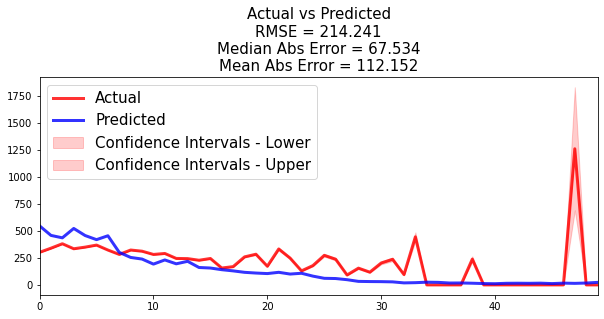

In [ ]:
## PREDICTION FOR SINGLE EXAMPLE
n_train = 20   # trainin size
n_test = 1   # test size

Sim_t = [i for i in range(0,31)]

freq = 'Day' # data frequence
first_run = '2022-08-08' # monday
last_run = '2022-08-08' # monday

algo = 'linear'

balance_classes = True
model_exp = True



# define model
if algo == 'deep':
  model = NeuralMultiTaskModel(structure=[{'activation': 'ReLU', 'num_units': 124},], 
                               bins=300)
elif algo == 'linear':
  model = LinearMultiTaskModel(bins=200)
elif algo == 'ext':
  model = ExtraSurvivalTreesModel(num_trees=200)
elif algo == 'con_forest':
  model = ConditionalSurvivalForestModel(num_trees=200)
elif algo == 'forest':
  model = RandomSurvivalForestModel(num_trees=200)
else:
  print('unknown algo')

# loop for different run_date
survival = pd.DataFrame()
#for customer in df_sur.customer_id.unique():
#  for product in df_sur[(df_sur.customer_id == customer)].product_id.unique():
for d in pd.date_range(start=first_run, end=last_run, freq=freq[0]):


  # split train&test
  train = df_sur[#(df_sur.customer_id == customer)&
                 #(df_sur.product_id == product)&
                  (df_sur.index < d)]
  test = df_sur[#(df_sur.customer_id == customer)&
                #(df_sur.product_id == product)&
                (df_sur.index >= d)]

  # undersample
  if balance_classes:
    #print("pre-sampling: \n", train.dropna().e.value_counts(),sep="")
    train = downsample(train.dropna())
    #print("\npost-sampling: \n", train.dropna().e.value_counts(),sep="")

  # split 'x' from 'e'
  X_train, X_test = train.drop(columns = ["order_qty","e"]), test.drop(columns = ["order_qty","e"])
  e_train, e_test = train['e'], test['e']

  # split 't' from 'x'
  t_train = X_train["t"] 
  x_train = X_train.drop(columns=["week_end","t"])
  t_test = X_test["t"] 
  x_test = X_test.drop(columns=["week_end","t"])          

  # train the model & make the predictions
  if algo == 'deep':
    model.fit(x_train, t_train, e_train, lr=1e-5, num_epochs = 500,
              dropout = 0.2,batch_normalization=False,
              l2_reg=1e-2, l2_smooth=1e-2, 
              optimizer = 'adam')
  elif algo == 'linear':
    model.fit(x_train, t_train, e_train,
              lr = 1e-4, num_epochs = 1000, l2_reg=1e-2, l2_smooth=1e-2)
  elif algo == 'ext':
    model.fit(x_train, t_train, e_train,
              max_features="sqrt", max_depth=5, min_node_size=20,
              num_random_splits = 500)
  elif algo == 'con_forest':
    model.fit(x_train, t_train, e_train,
              max_features="sqrt", max_depth=5, min_node_size=20,
              alpha = 0.05, minprop=0.1)
  elif algo == 'forest':
    model.fit(x_train, t_train, e_train,
              max_features="sqrt", max_depth=5, min_node_size=20)
  else:
    print("unknown algo")
    
  if model_exp:
    compare_to_actual(model, x_test, t_test, e_test,
              is_at_risk = False,  figure_size=(10, 4),
              metrics = ['rmse', 'mean', 'median'])
      
  for sim_t in Sim_t:
    p = model.predict_survival(x=x_test, t=sim_t).round(2)

    # Write the results in dict.
    sur = X_test.drop(columns=[c for c in X_test.columns if 'shifted' in c])
    sur['prediction'] = 1-p
    sur['t'] = sim_t
    survival = pd.concat([survival,sur])
survival = survival.reset_index()[['date', 'week_end', 
                                   'customer_id', 'customer_grp', 'product_id', 'product_grp',
                                   't', 'prediction']].fillna(0)

In [ ]:
survival[(survival.customer_id == 789903)&
         (survival.product_id == 25891603)&
         (survival.date == "2022-08-08")]

date   week_end  customer_id  customer_grp  product_id  \
16983  2022-08-08 2022-08-14       789903          7899    25891603   
33993  2022-08-08 2022-08-14       789903          7899    25891603   
51003  2022-08-08 2022-08-14       789903          7899    25891603   
68013  2022-08-08 2022-08-14       789903          7899    25891603   
85023  2022-08-08 2022-08-14       789903          7899    25891603   
102033 2022-08-08 2022-08-14       789903          7899    25891603   
119043 2022-08-08 2022-08-14       789903          7899    25891603   
136053 2022-08-08 2022-08-14       789903          7899    25891603   
153063 2022-08-08 2022-08-14       789903          7899    25891603   
170073 2022-08-08 2022-08-14       789903          7899    25891603   
187083 2022-08-08 2022-08-14       789903          7899    25891603   
204093 2022-08-08 2022-08-14       789903          7899    25891603   
221103 2022-08-08 2022-08-14       789903          7899    25891603   
238113 2022-08-08 2022-08-14       789903          7899    25891603   
255123 2022-08-08 2022-08-14       789903          7899    25891603   
272133 2022-08-08 2022-08-14       789903          7899    25891603   
289143 2022-08-08 2022-08-14       789903          7899    25891603   
306153 2022-08-08 2022-08-14       789903          7899    25891603   
323163 2022-08-08 2022-08-14       789903          7899    25891603   
340173 2022-08-08 2022-08-14       789903          7899    25891603   
357183 2022-08-08 2022-08-14       789903          7899    25891603   
374193 2022-08-08 2022-08-14       789903          7899    25891603   
391203 2022-08-08 2022-08-14       789903          7899    25891603   
408213 2022-08-08 2022-08-14       789903          7899    25891603   
425223 2022-08-08 2022-08-14       789903          7899    25891603   
442233 2022-08-08 2022-08-14       789903          7899    25891603   
459243 2022-08-08 2022-08-14       789903          7899    25891603   
476253 2022-08-08 2022-08-14       789903          7899    25891603   
493263 2022-08-08 2022-08-14       789903          7899    25891603   
510273 2022-08-08 2022-08-14       789903          7899    25891603   
527283 2022-08-08 2022-08-14       789903          7899    25891603   

        product_grp   t  prediction  
16983        258916   0        0.00  
33993        258916   1        0.07  
51003        258916   2        0.16  
68013        258916   3        0.23  
85023        258916   4        0.32  
102033       258916   5        0.38  
119043       258916   6        0.45  
136053       258916   7        0.52  
153063       258916   8        0.56  
170073       258916   9        0.61  
187083       258916  10        0.65  
204093       258916  11        0.68  
221103       258916  12        0.71  
238113       258916  13        0.76  
255123       258916  14        0.79  
272133       258916  15        0.81  
289143       258916  16        0.84  
306153       258916  17        0.85  
323163       258916  18        0.86  
340173       258916  19        0.88  
357183       258916  20        0.90  
374193       258916  21        0.92  
391203       258916  22        0.93  
408213       258916  23        0.94  
425223       258916  24        0.95  
442233       258916  25        0.95  
459243       258916  26        0.96  
476253       258916  27        0.96  
493263       258916  28        0.96  
510273       258916  29        0.96  
527283       258916  30        0.96

In [ ]:
survival[(survival.date == "2022-08-08")&
         (survival.customer_id == 789903)&
         (survival.product_id == 25891502)]

date   week_end  customer_id  customer_grp  product_id  \
16875  2022-08-08 2022-08-14       789903          7899    25891502   
33885  2022-08-08 2022-08-14       789903          7899    25891502   
50895  2022-08-08 2022-08-14       789903          7899    25891502   
67905  2022-08-08 2022-08-14       789903          7899    25891502   
84915  2022-08-08 2022-08-14       789903          7899    25891502   
101925 2022-08-08 2022-08-14       789903          7899    25891502   
118935 2022-08-08 2022-08-14       789903          7899    25891502   
135945 2022-08-08 2022-08-14       789903          7899    25891502   
152955 2022-08-08 2022-08-14       789903          7899    25891502   
169965 2022-08-08 2022-08-14       789903          7899    25891502   
186975 2022-08-08 2022-08-14       789903          7899    25891502   
203985 2022-08-08 2022-08-14       789903          7899    25891502   
220995 2022-08-08 2022-08-14       789903          7899    25891502   
238005 2022-08-08 2022-08-14       789903          7899    25891502   
255015 2022-08-08 2022-08-14       789903          7899    25891502   
272025 2022-08-08 2022-08-14       789903          7899    25891502   
289035 2022-08-08 2022-08-14       789903          7899    25891502   
306045 2022-08-08 2022-08-14       789903          7899    25891502   
323055 2022-08-08 2022-08-14       789903          7899    25891502   
340065 2022-08-08 2022-08-14       789903          7899    25891502   
357075 2022-08-08 2022-08-14       789903          7899    25891502   
374085 2022-08-08 2022-08-14       789903          7899    25891502   
391095 2022-08-08 2022-08-14       789903          7899    25891502   
408105 2022-08-08 2022-08-14       789903          7899    25891502   
425115 2022-08-08 2022-08-14       789903          7899    25891502   
442125 2022-08-08 2022-08-14       789903          7899    25891502   
459135 2022-08-08 2022-08-14       789903          7899    25891502   
476145 2022-08-08 2022-08-14       789903          7899    25891502   
493155 2022-08-08 2022-08-14       789903          7899    25891502   
510165 2022-08-08 2022-08-14       789903          7899    25891502   
527175 2022-08-08 2022-08-14       789903          7899    25891502   

        product_grp   t  prediction  
16875        258915   0        0.00  
33885        258915   1        0.07  
50895        258915   2        0.17  
67905        258915   3        0.24  
84915        258915   4        0.33  
101925       258915   5        0.39  
118935       258915   6        0.45  
135945       258915   7        0.53  
152955       258915   8        0.57  
169965       258915   9        0.62  
186975       258915  10        0.66  
203985       258915  11        0.68  
220995       258915  12        0.71  
238005       258915  13        0.75  
255015       258915  14        0.78  
272025       258915  15        0.80  
289035       258915  16        0.82  
306045       258915  17        0.84  
323055       258915  18        0.84  
340065       258915  19        0.86  
357075       258915  20        0.87  
374085       258915  21        0.90  
391095       258915  22        0.91  
408105       258915  23        0.92  
425115       258915  24        0.93  
442125       258915  25        0.94  
459135       258915  26        0.94  
476145       258915  27        0.95  
493155       258915  28        0.95  
510165       258915  29        0.95  
527175       258915  30        0.95

In [ ]:
survival[(survival.date == "2022-08-08")&
         (survival.customer_id == 789903)&
         (survival.product_id == 25891603)]

date   week_end  customer_id  customer_grp  product_id  \
16983  2022-08-08 2022-08-14       789903          7899    25891603   
33993  2022-08-08 2022-08-14       789903          7899    25891603   
51003  2022-08-08 2022-08-14       789903          7899    25891603   
68013  2022-08-08 2022-08-14       789903          7899    25891603   
85023  2022-08-08 2022-08-14       789903          7899    25891603   
102033 2022-08-08 2022-08-14       789903          7899    25891603   
119043 2022-08-08 2022-08-14       789903          7899    25891603   
136053 2022-08-08 2022-08-14       789903          7899    25891603   
153063 2022-08-08 2022-08-14       789903          7899    25891603   
170073 2022-08-08 2022-08-14       789903          7899    25891603   
187083 2022-08-08 2022-08-14       789903          7899    25891603   
204093 2022-08-08 2022-08-14       789903          7899    25891603   
221103 2022-08-08 2022-08-14       789903          7899    25891603   
238113 2022-08-08 2022-08-14       789903          7899    25891603   
255123 2022-08-08 2022-08-14       789903          7899    25891603   
272133 2022-08-08 2022-08-14       789903          7899    25891603   
289143 2022-08-08 2022-08-14       789903          7899    25891603   
306153 2022-08-08 2022-08-14       789903          7899    25891603   
323163 2022-08-08 2022-08-14       789903          7899    25891603   
340173 2022-08-08 2022-08-14       789903          7899    25891603   
357183 2022-08-08 2022-08-14       789903          7899    25891603   
374193 2022-08-08 2022-08-14       789903          7899    25891603   
391203 2022-08-08 2022-08-14       789903          7899    25891603   
408213 2022-08-08 2022-08-14       789903          7899    25891603   
425223 2022-08-08 2022-08-14       789903          7899    25891603   
442233 2022-08-08 2022-08-14       789903          7899    25891603   
459243 2022-08-08 2022-08-14       789903          7899    25891603   
476253 2022-08-08 2022-08-14       789903          7899    25891603   
493263 2022-08-08 2022-08-14       789903          7899    25891603   
510273 2022-08-08 2022-08-14       789903          7899    25891603   
527283 2022-08-08 2022-08-14       789903          7899    25891603   

        product_grp   t  prediction  
16983        258916   0        0.00  
33993        258916   1        0.07  
51003        258916   2        0.16  
68013        258916   3        0.23  
85023        258916   4        0.32  
102033       258916   5        0.38  
119043       258916   6        0.45  
136053       258916   7        0.52  
153063       258916   8        0.56  
170073       258916   9        0.61  
187083       258916  10        0.65  
204093       258916  11        0.68  
221103       258916  12        0.71  
238113       258916  13        0.76  
255123       258916  14        0.79  
272133       258916  15        0.81  
289143       258916  16        0.84  
306153       258916  17        0.85  
323163       258916  18        0.86  
340173       258916  19        0.88  
357183       258916  20        0.90  
374193       258916  21        0.92  
391203       258916  22        0.93  
408213       258916  23        0.94  
425223       258916  24        0.95  
442233       258916  25        0.95  
459243       258916  26        0.96  
476253       258916  27        0.96  
493263       258916  28        0.96  
510273       258916  29        0.96  
527283       258916  30        0.96

## Breakdown

In [ ]:
# prepare predictions for merge
pre = predictions.copy()
pre = pre.drop(columns=["run_date"]).rename(columns={"date":"week_end",
                                                     "order_qty":"weekly_sum",
                                                     "prediction":"weekly_sum_pred"})

# prepare survival for merge
sur = survival.copy()
sur = sur.rename(columns={"prediction":"survival_ratio_pred"})

# merge data 
breakdown = pd.merge(pre, sur,
                     on=["week_end","customer_grp","product_grp"],
                     how="left")

del pre, sur

In [ ]:
# last one month of breakdown ratios
h1 = df_sur[(df_sur.index >= "2022-03-01")&
       (df_sur.index < "2022-08-01")].reset_index().groupby(["customer_id","customer_grp","product_id","product_grp"]
                             ).agg(h1_sum= ("order_qty","sum")).reset_index() 
                             
                             
h2 = df_sur[(df_sur.index >= "2022-03-01")&
            (df_sur.index < "2022-08-01")].reset_index().groupby(["customer_grp","product_grp"]
                                  ).agg(h2_sum= ("order_qty","sum")).reset_index()                                      

brk_df = pd.merge(h1, h2, on=["customer_grp","product_grp"])                              
brk_df["breakdown_ratio"] = brk_df["h1_sum"] / brk_df["h2_sum"]


breakdown = pd.merge(breakdown, 
                     brk_df.drop(columns=["h1_sum","h2_sum"]), 
                     how="left")

del h1, h2, brk_df

In [ ]:
breakdown.head()

week_end  weekly_sum  weekly_sum_pred  customer_grp  product_grp  \
0 2022-08-14       224.0       222.436459          7891       258911   
1 2022-08-14       224.0       222.436459          7891       258911   
2 2022-08-14       224.0       222.436459          7891       258911   
3 2022-08-14       224.0       222.436459          7891       258911   
4 2022-08-14       224.0       222.436459          7891       258911   

        date  customer_id  product_id  t  survival_ratio_pred  breakdown_ratio  
0 2022-08-08       789101    25891101  0                  0.0         0.054899  
1 2022-08-09       789101    25891101  0                  0.0         0.054899  
2 2022-08-10       789101    25891101  0                  0.0         0.054899  
3 2022-08-11       789101    25891101  0                  0.0         0.054899  
4 2022-08-12       789101    25891101  0                  0.0         0.054899

In [ ]:
# args.
alpha = 0.5
given_date_list = pd.date_range("2022-08-08","2022-08-21")


# define date finder
def passive_date(x, a, b):
  """
  given_date_list = pd.date_range("2022-08-08","2022-08-14")

  abc = pd.DataFrame({"customer_id":[1, 1, 2, 2],
                      "product_id":['a','b','a','b'],
                      "t_ideal":[5, 8, 14, 18],
                      "t_current":[2, 7, 14, 20]})

  ABC = pd.DataFrame()
  for given_date in given_date_list:
    abc["run_date"] = given_date
    abc["predicted_sales_date"] = abc.apply(lambda x: passive_date(given_date, x["t_ideal"], x["t_current"]), axis=1)
    abc["t_current"] += 1
    
    ABC = pd.concat([ABC, abc])

    idx = abc[abc.run_date == abc.predicted_sales_date].index
    abc.loc[idx, 't_current'] = 0

  ABC[["run_date","customer_id","product_id","t_ideal","t_current","predicted_sales_date"]]
  """
  if a > b:
    d = pd.to_datetime(x) + timedelta(days=(int(a)-int(b)-1))
  elif a <= b:
    d = pd.to_datetime(x)
  return d


purchase_after_t = breakdown[breakdown.survival_ratio_pred >= alpha
                            ].groupby(["customer_id","product_id"]
                                      ).agg(t_ideal = ("t","min")).reset_index()

given_date = str(given_date_list[0].date())
current_t = df_sur[df_sur.index == given_date]\
                              [["customer_id","product_id","t"]]\
                              .reset_index(drop=True)\
                              .rename(columns={"t":"t_current"})

t_table = pd.merge(purchase_after_t, current_t, 
                   on=["customer_id","product_id"],
                   how="inner")    

ttable = pd.DataFrame()
for given_date in given_date_list:
  t_table["date"] = given_date
  t_table['predicted_sales_date'] = t_table.apply(lambda x: passive_date(given_date, x["t_ideal"], x["t_current"]), axis=1)
  t_table["t_current"] += 1

  ttable = pd.concat([ttable, t_table])

  idx = t_table[t_table["date"] == t_table["predicted_sales_date"]].index
  t_table.loc[idx, 't_current'] = 0

print("---------------------\n")
print("raw shape",ttable.shape)
ttable = ttable[["customer_id","product_id","predicted_sales_date"]].drop_duplicates().reset_index(drop=True)
print("clean shape",ttable.shape)
print("\n---------------------\n")

#del purchase_after_t, current_t, t_table

---------------------

raw shape (8820, 6)
clean shape (1634, 3)

---------------------



In [ ]:
print(breakdown.shape)
final_result = pd.merge(breakdown,
                        ttable.rename(columns={"predicted_sales_date":"date"}).assign(buy_decision=1),
                        how="left").fillna(0.0)
print(final_result.shape)

# final prediction
final_result["pred"] = (final_result["weekly_sum_pred"] \
                        * final_result["breakdown_ratio"] \
                        * final_result["buy_decision"]
                        ).astype('int') 

col = ["date","customer_id","product_id","pred"]
final_result = final_result[col].drop_duplicates()
final_result.head()

(273420, 11)
(273420, 12)


date  customer_id  product_id  pred
0 2022-08-08       789101    25891101     0
1 2022-08-09       789101    25891101     0
2 2022-08-10       789101    25891101     0
3 2022-08-11       789101    25891101     0
4 2022-08-12       789101    25891101     0

In [ ]:
final_result[(final_result.customer_id == 789101)&
             (final_result.product_id == 25891201)]

date  customer_id  product_id  pred
6510 2022-08-08       789101    25891201     0
6511 2022-08-09       789101    25891201     0
6512 2022-08-10       789101    25891201     0
6513 2022-08-11       789101    25891201     0
6514 2022-08-12       789101    25891201     0
6515 2022-08-13       789101    25891201     0
6516 2022-08-14       789101    25891201     0
9765 2022-08-15       789101    25891201     0
9766 2022-08-16       789101    25891201     0
9767 2022-08-17       789101    25891201   100
9768 2022-08-18       789101    25891201     0
9769 2022-08-19       789101    25891201     0
9770 2022-08-20       789101    25891201     0
9771 2022-08-21       789101    25891201     0

## Compare Result (unfinished!)

In [ ]:
real = df_sur.iloc[:,:8].copy().reset_index()
real = real[(real.week_end.isin(["2022-08-14","2022-08-21"]))
            ][["date","customer_id","product_id","t","order_qty"]]

print(real.shape)
print(final_result.shape)
m = pd.merge(real, final_result,
             on=["date","customer_id","product_id"],
             how="left")
m.shape

(8820, 5)
(8820, 4)


(8820, 6)

In [ ]:
m[(m.customer_id == 789201)&
  (m.product_id == 25891302)]

date  customer_id  product_id    t  order_qty  pred
1358 2022-08-08       789201    25891302  0.0        0.0     0
1359 2022-08-09       789201    25891302  1.0        0.0     0
1360 2022-08-10       789201    25891302  2.0        0.0     0
1361 2022-08-11       789201    25891302  3.0        0.0     0
1362 2022-08-12       789201    25891302  4.0        0.0     0
1363 2022-08-13       789201    25891302  5.0        0.0     0
1364 2022-08-14       789201    25891302  6.0        0.0     0
1365 2022-08-15       789201    25891302  7.0       27.0    20
1366 2022-08-16       789201    25891302  0.0        0.0     0
1367 2022-08-17       789201    25891302  1.0        0.0     0
1368 2022-08-18       789201    25891302  2.0        0.0     0
1369 2022-08-19       789201    25891302  3.0        0.0     0
1370 2022-08-20       789201    25891302  4.0        0.0     0
1371 2022-08-21       789201    25891302  5.0        0.0     0

In [ ]:
m_summ = m.groupby(["customer_id","product_id"]).agg(real_sum = ("order_qty","sum"),
                                                     predicted_sum =("pred","sum"))
m_summ["error"] = abs(m_summ["real_sum"] - m_summ["predicted_sum"])
m_summ.sort_values("error")

real_sum  predicted_sum  error
customer_id product_id                                
789122      25891503        31.0             31    0.0
789321      25891202         0.0              0    0.0
789320      25891502        57.0             57    0.0
789201      25891302        27.0             27    0.0
789301      25891302        20.0             20    0.0
...                          ...            ...    ...
789221      25891201       668.0            287  381.0
789420      25891201       564.0            166  398.0
789201      25891201         0.0            413  413.0
789702      25891202       528.0            105  423.0
789301      25891203       439.0              0  439.0

[630 rows x 3 columns]

In [ ]:
m_summ.describe()

real_sum  predicted_sum       error
count  630.000000     630.000000  630.000000
mean    83.938095      66.066667   54.861905
std     92.440645      62.583911   67.260911
min      0.000000       0.000000    0.000000
25%     25.000000      23.000000   14.000000
50%     56.000000      50.000000   32.500000
75%    106.000000      87.750000   69.000000
max    668.000000     413.000000  439.000000